# Time Series Forecasting

## Setup

In [1]:
from google.colab import drive

drive.mount("./gdrive", force_remount=True)
%cd "./gdrive/My Drive/Colab Notebooks/sampco"

Mounted at ./gdrive
/content/gdrive/My Drive/Colab Notebooks/sampco


In [2]:
!pip install hampel statsmodels -q -U

     |████████████████████████████████| 9.5MB 9.0MB/s 


In [25]:
from hampel import hampel

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib as mpl
import matplotlib.pyplot as plt

import IPython
import IPython.display

import tensorflow as tf
import pandas as pd
import numpy as np
import datetime as dt

mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.grid"] = False
mpl.rcParams["figure.figsize"] = (30, 7)

## Dataset

In [44]:
columns = [
    # "_CustomerKey",
    # "_PayerKey",
    # "_ShipToKey",
    # "_SoldToKey",
    # "_MaterialKey",
    "_CalendarKey",
    "TransactionType",
    # "Company",
    # "DocumentType",
    # "SalesChannel",
    # "SalesRepresentative",
    "SoldVolume",
    # "CasesSold",
    "VolumeUnit",
    "Revenue",
    # "Cogs",
    # "FreightRevenue",
    # # "FreightCost",
    # "Commission",
    # "Allowance",
    # "Discount",
    # "NetRevenue",
    # "GrossMargin",
]

df = pd.read_csv("FactSales.csv", parse_dates=["_CalendarKey"], usecols=columns)

## Preprocessing Data

In [45]:
df = df[(df["TransactionType"] == "SALES") & (df["SoldVolume"] > 0)]
df.loc[df["VolumeUnit"] == "KG", "SoldVolume"] = df["SoldVolume"].apply(lambda x: x * 2.2046)

df.drop(["TransactionType", "VolumeUnit"], axis=1, inplace=True)

In [46]:
df1 = df.groupby(["_CalendarKey"]).size().reset_index(name="Sales")
df2 = df.groupby(by=["_CalendarKey"], as_index=False)[df.drop("_CalendarKey", axis=1).columns].sum()

df = pd.merge(df1, df2, how="left", on=["_CalendarKey"])

df.sort_values(by=["_CalendarKey"], ascending=True, ignore_index=True, inplace=True)
df.set_index("_CalendarKey", inplace=True)

In [47]:
timestamp_s = df.index.map(dt.datetime.timestamp)

df["Year sin"] = np.sin(timestamp_s * 2 * np.pi / 3.154e+7)
df["Year cos"] = np.cos(timestamp_s * 2 * np.pi / 3.154e+7)
df["Month sin"] = np.sin(timestamp_s * 2 * np.pi / 2.628e+6)
df["Month cos"] = np.cos(timestamp_s * 2 * np.pi / 2.628e+6)

In [ ]:
# for col in df.columns:
#     non_imp = hampel(df[col], window_size=30, n=3, imputation=False)
#     df[col] = hampel(df[col], window_size=30, n=3, imputation=True).values    

#     if non_imp:
#         print(col, "->", non_imp)

## Analysis

In [48]:
df

,Sales,SoldVolume,Revenue,Year sin,Year cos,Month sin,Month cos
_CalendarKey,,,,,,,
2018-12-31,20,55681.690208,138093.28,0.149721,0.988728,0.763889,-0.645348
2019-01-02,18,119117.100000,318997.77,0.183662,0.982989,0.440519,-0.897743
2019-01-03,43,232366.558640,586796.37,0.200553,0.979683,0.247022,-0.969010
2019-01-04,100,426322.966275,1146033.81,0.217385,0.976086,0.043022,-0.999074
2019-01-07,15,77328.761242,274216.19,0.267474,0.963565,-0.545240,-0.838280
...,...,...,...,...,...,...,...
2021-04-28,21,66919.500000,177102.80,0.810303,-0.586011,0.988678,-0.150055
2021-04-29,59,398094.388800,1181409.59,0.800097,-0.599870,0.936881,-0.349647
2021-04-30,30,87210.000000,275325.22,0.789654,-0.613552,0.845249,-0.534373


In [49]:
df.describe()

,Sales,SoldVolume,Revenue,Year sin,Year cos,Month sin,Month cos
count,687.000000,6.870000e+02,6.870000e+02,687.000000,687.000000,687.000000,687.000000
mean,59.144105,2.966483e+05,7.919298e+05,0.112864,0.019967,0.021357,0.013416
std,34.181362,2.062888e+05,5.336468e+05,0.715542,0.690145,0.716822,0.697845
min,1.000000,1.170000e+02,3.073200e+02,-0.999999,-0.999994,-0.999991,-0.999963
25%,34.500000,1.492016e+05,3.943267e+05,-0.604816,-0.636380,-0.699458,-0.664831
50%,57.000000,2.669116e+05,7.224062e+05,0.250079,0.033501,0.034422,0.004304
75%,78.000000,4.036086e+05,1.112101e+06,0.820041,0.693871,0.755486,0.708600
max,202.000000,1.692884e+06,3.011296e+06,0.999979,0.999981,0.999991,1.000000


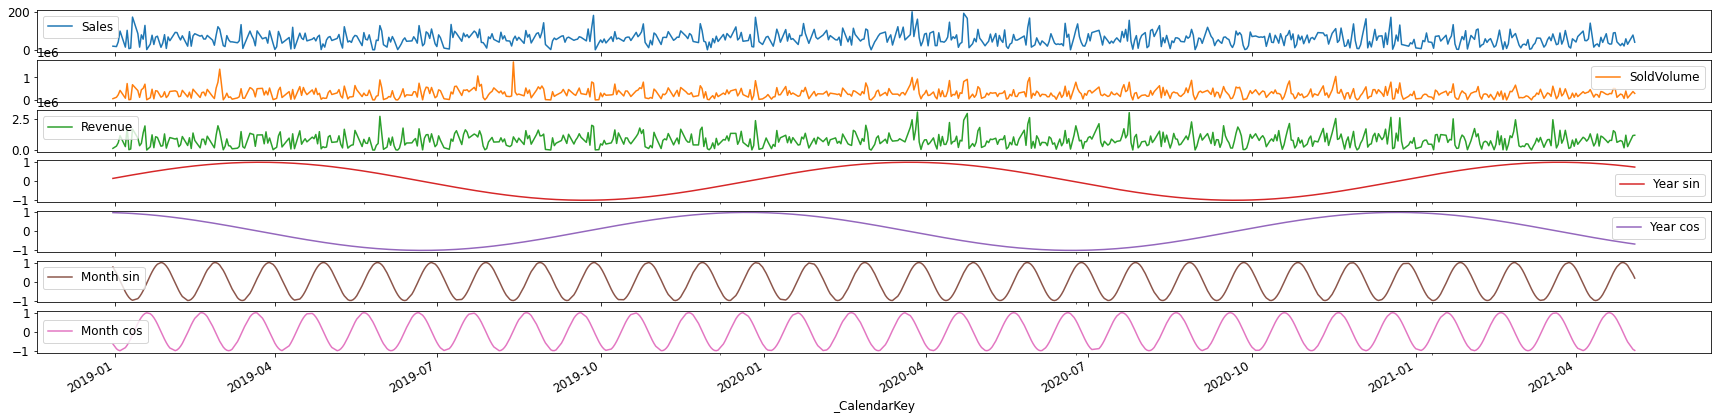

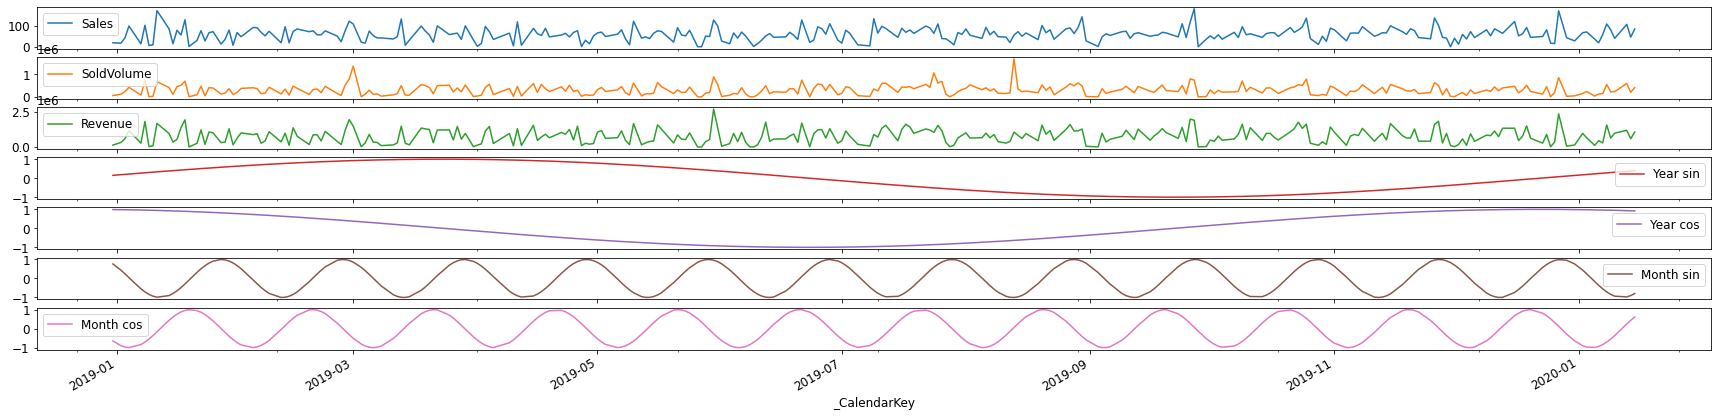

In [50]:
_ = df.plot(subplots=True)
_ = df[:290].plot(subplots=True)

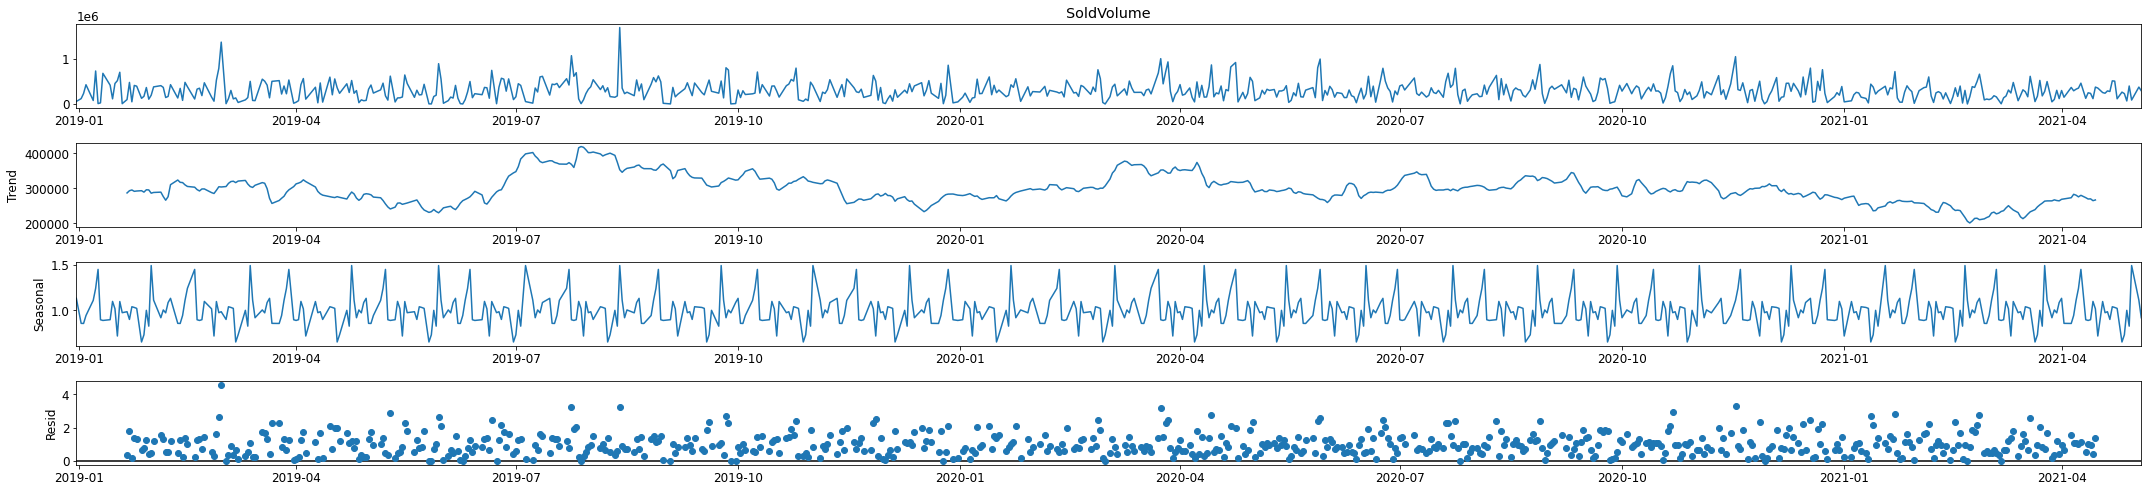

In [51]:
_ = seasonal_decompose(df["SoldVolume"], period=30, model="multiplicative").plot()

## Split the Data

In [52]:
data = df.copy()

train_index = int(len(df) * 0.70)
valid_index = int(len(df) * 0.85)

train_df = data[:train_index]
valid_df = data[train_index-300:valid_index]
test_df = data[valid_index-300:]

In [53]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(train_df)

train_df = pd.DataFrame(scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
valid_df = pd.DataFrame(scaler.transform(valid_df), index=valid_df.index, columns=valid_df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), index=test_df.index, columns=test_df.columns)

In [54]:
train_df

,Sales,SoldVolume,Revenue,Year sin,Year cos,Month sin,Month cos
_CalendarKey,,,,,,,
2018-12-31,0.094527,0.032825,0.045761,0.574840,0.994399,0.881948,0.177311
2019-01-02,0.084577,0.070299,0.105842,0.591812,0.991529,0.720261,0.051111
2019-01-03,0.208955,0.137201,0.194783,0.600258,0.989876,0.623512,0.015477
2019-01-04,0.492537,0.251781,0.380515,0.608675,0.988077,0.521511,0.000444
2019-01-07,0.069652,0.045613,0.090970,0.633721,0.981817,0.227377,0.080843
...,...,...,...,...,...,...,...
2020-08-28,0.537313,0.516893,0.742220,0.042339,0.298504,0.988010,0.391127
2020-08-29,0.383085,0.135002,0.368733,0.038938,0.306410,0.955307,0.293348
2020-08-30,0.004975,0.008065,0.003317,0.035674,0.314373,0.903244,0.204355


## Data Windowing

In [55]:
class WindowGenerator():
    def __init__(self, train, valid, test, input_width, label_width,
                 shift=None, label_columns=None, batch_size=8):

        # Store the raw data
        self.train_df = train
        self.valid_df = valid
        self.test_df = test

        self.batch_size = batch_size

        # Work out the label column indices
        self.label_columns = train.columns if label_columns is None else label_columns
        self.label_columns_indices = {name: i for i, name in enumerate(self.label_columns)}

        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width

        self.window_size = input_width + (label_width if shift is None else shift)
        self.input_slice = slice(0, input_width)

        self.input_indices = np.arange(self.window_size)[self.input_slice]
        self.input_indices_date = test.index[self.input_indices]

        self.label_start = self.window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)

        self.label_indices = np.arange(self.window_size)[self.labels_slice]
        self.label_indices_date = test.index[self.label_indices]

    def __repr__(self):
        info = [f"Total window size: {self.window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {list(self.label_columns)}\n"]

        for example_inputs, example_labels in self.train.take(1):
            info.append(f"Inputs shape (batch, time, features): {example_inputs.shape}")
            info.append(f"Labels shape (batch, time, features): {example_labels.shape}")
        return "\n".join(info)

    def split_window(self, features):
        inputs = features[:, self.input_slice,:]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]]
                               for name in self.label_columns], axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)

        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data, targets=None, sequence_length=self.window_size,
            sequence_stride=1, shuffle=False, batch_size=self.batch_size)

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def valid(self):
        return self.make_dataset(self.valid_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    def plot(self, col, model=None, max_subplots=3):
        total = len(self.test_df)
        splits = [i for i in range(0, total, self.window_size) if i + self.window_size < total]

        window = tf.stack([self.test_df[s : s + self.window_size] for s in splits[:max_subplots]])
        inputs, labels = self.split_window(window)

        plt.figure(figsize=(30, 3 * len(inputs)))
        plot_col_index = self.column_indices[col]

        for n in range(len(inputs)):
            plt.subplot(len(inputs), 1, n+1)
            plt.ylabel(f"{col} [normed]")

            plt.plot(self.input_indices_date, inputs[n, :, plot_col_index], 
                     label="Inputs", marker=".", zorder=-10)

            if self.label_columns is None:
                label_col_index = plot_col_index
            else:
                label_col_index = self.label_columns_indices.get(col, None)

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices_date, labels[n, :, label_col_index],
                        edgecolors="k", label="Labels", c="#2ca02c", s=64)
            
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices_date, predictions[n, :, label_col_index],
                            marker="X", edgecolors="k", label="Predictions", c="#ff7f0e", s=64)
            if n == 0:
                plt.legend()

        plt.xlabel("Time [d]")

Total window size: 360
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

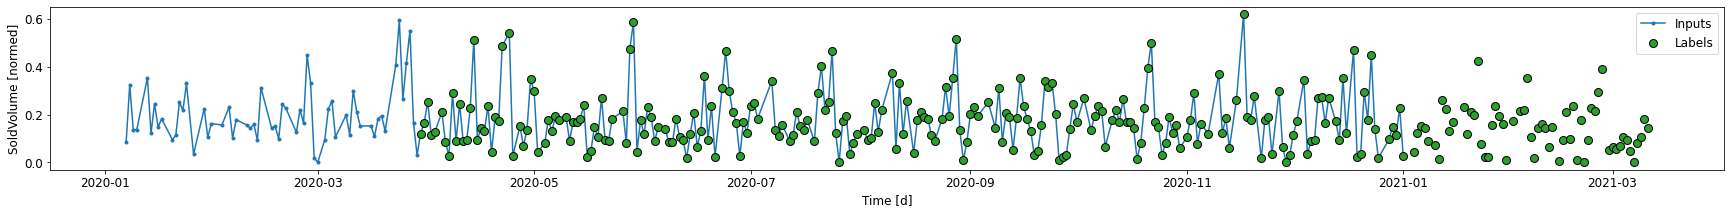

In [56]:
OUT_STEPS = 300

multi_window = WindowGenerator(train=train_df,
                               valid=valid_df,
                               test=test_df,
                            #    label_columns=["SoldVolume"],
                               input_width=OUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=60,
                               batch_size=2)

multi_window.plot(col="SoldVolume")
multi_window

## Model

In [57]:
def compile_and_fit(model, window, lr=0.001, patience=10):
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=lr))

    stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
    history = model.fit(window.train, epochs=10000, validation_data=window.valid, callbacks=[stopping])
    return history

## Multi-Step Models

## Baselines

22/22 [==============================] - 0s 1ms/step - loss: 0.1599


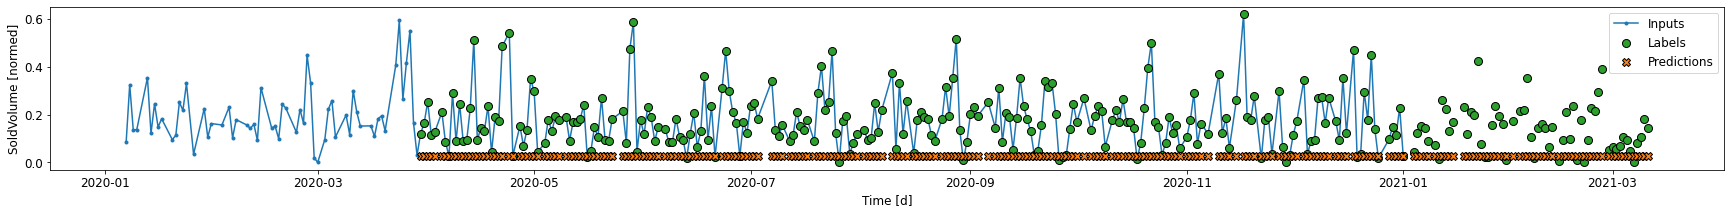

In [58]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])


last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError())

multi_performance = {}
multi_val_performance = {}

multi_performance["Last"] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_val_performance["Last"] = last_baseline.evaluate(multi_window.valid)

multi_window.plot(col="SoldVolume", model=last_baseline)

22/22 [==============================] - 0s 1ms/step - loss: 0.1575


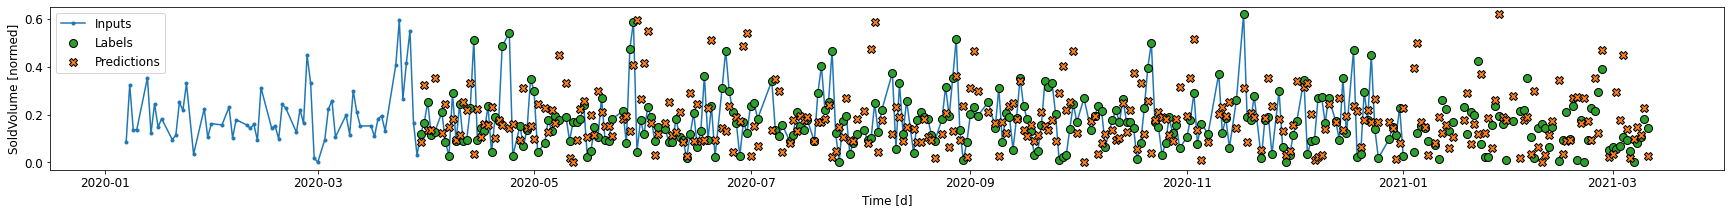

In [59]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError())

multi_performance["Repeat"] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_val_performance["Repeat"] = repeat_baseline.evaluate(multi_window.valid)

multi_window.plot(col="SoldVolume", model=repeat_baseline)

## Linear

In [60]:
n_features = train_df.shape[1]

multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),

    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(OUT_STEPS * n_features)),

    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, n_features])
])

history = compile_and_fit(multi_linear_model, multi_window, lr=0.0001, patience=20)
IPython.display.clear_output()

multi_val_performance["Linear"] = multi_linear_model.evaluate(multi_window.valid)
multi_performance["Linear"] = multi_linear_model.evaluate(multi_window.test, verbose=0)

22/22 [==============================] - 0s 1ms/step - loss: 0.1395


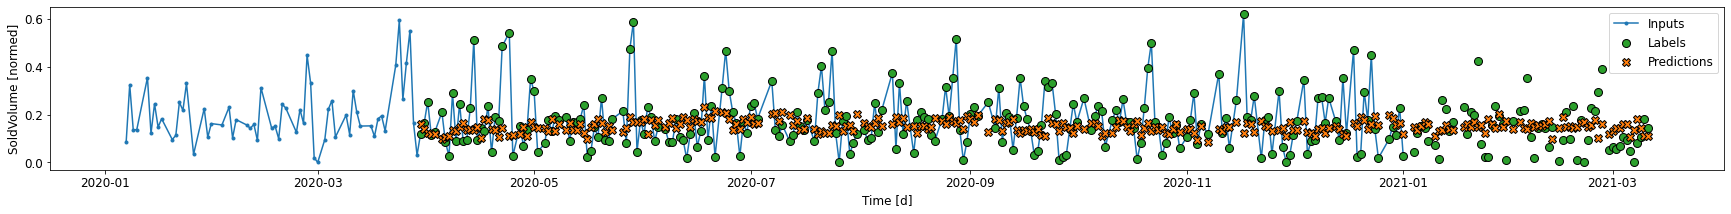

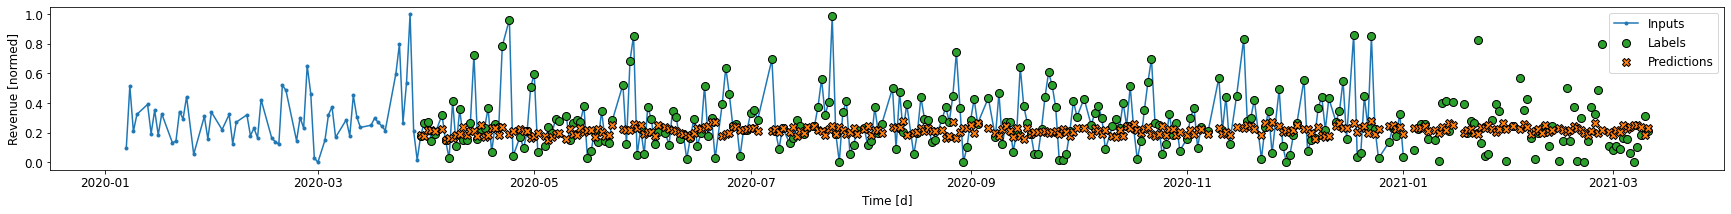

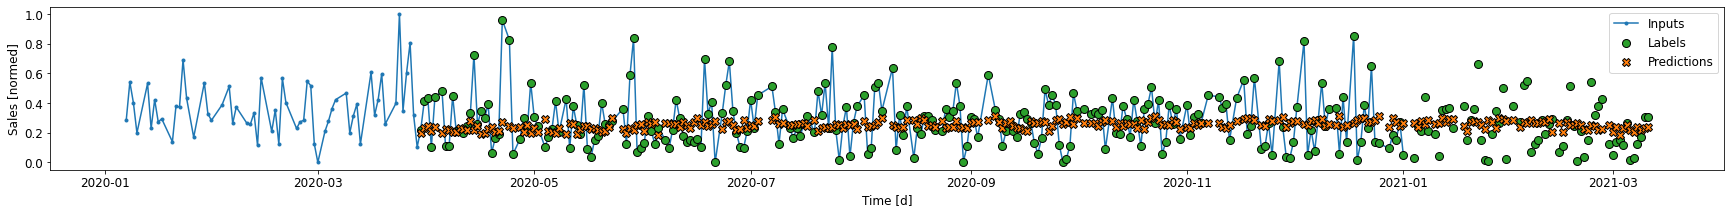

In [61]:
multi_window.plot(col="SoldVolume", model=multi_linear_model)
multi_window.plot(col="Revenue", model=multi_linear_model)
multi_window.plot(col="Sales", model=multi_linear_model)

## Dense

In [62]:
n_features = train_df.shape[1]

multi_dense_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),

    tf.keras.layers.Dense(512, activation="relu"),

    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(OUT_STEPS * n_features)),

    # tf.keras.layers.Dense(OUT_STEPS * n_features),

    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, n_features])
])

history = compile_and_fit(multi_dense_model, multi_window, lr=0.0001, patience=20)
IPython.display.clear_output()

multi_val_performance["Dense"] = multi_dense_model.evaluate(multi_window.valid)
multi_performance["Dense"] = multi_dense_model.evaluate(multi_window.test, verbose=0)

22/22 [==============================] - 0s 2ms/step - loss: 0.1417


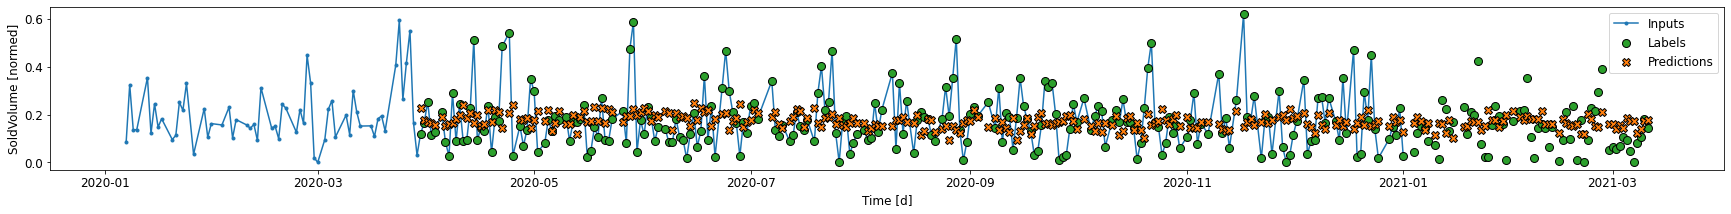

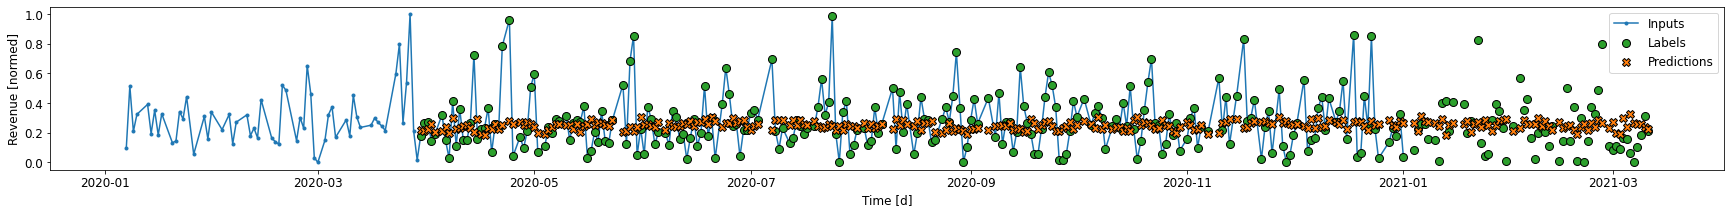

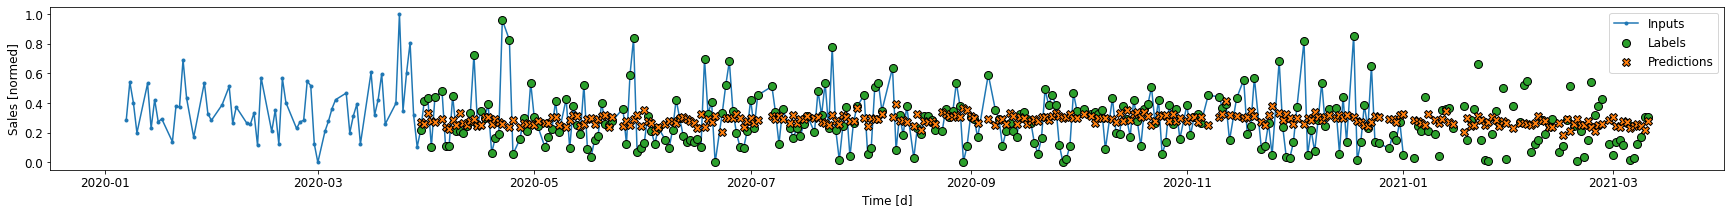

In [63]:
multi_window.plot(col="SoldVolume", model=multi_dense_model)
multi_window.plot(col="Revenue", model=multi_dense_model)
multi_window.plot(col="Sales", model=multi_dense_model)

## Convolution Neural Network

In [64]:
CONV_WIDTH = 3

multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),

    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH)),

    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(OUT_STEPS * n_features)),

    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, n_features])
])


history = compile_and_fit(multi_conv_model, multi_window, lr=0.0001, patience=20)
IPython.display.clear_output()

multi_val_performance["Conv"] = multi_conv_model.evaluate(multi_window.valid)
multi_performance["Conv"] = multi_conv_model.evaluate(multi_window.test, verbose=0)

22/22 [==============================] - 0s 2ms/step - loss: 0.1408


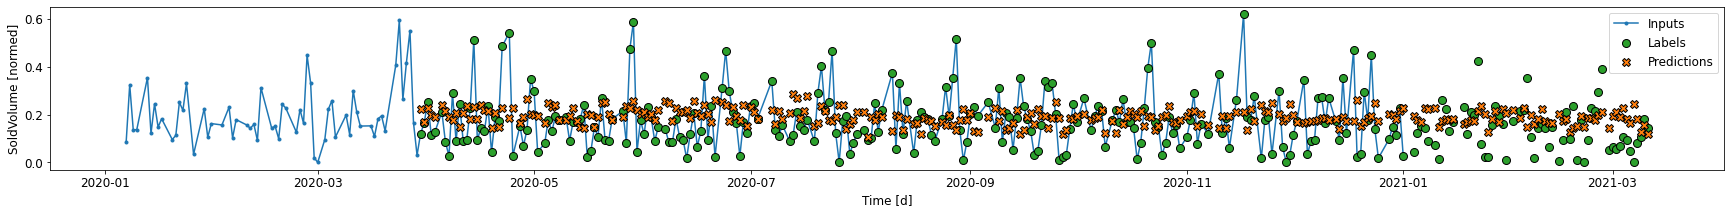

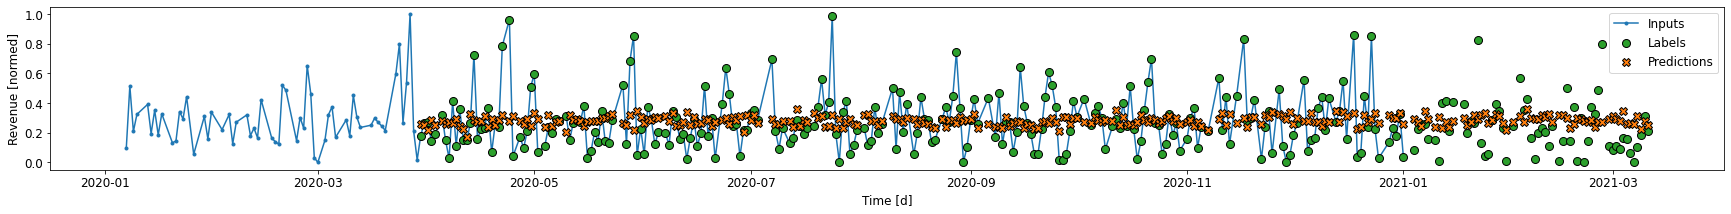

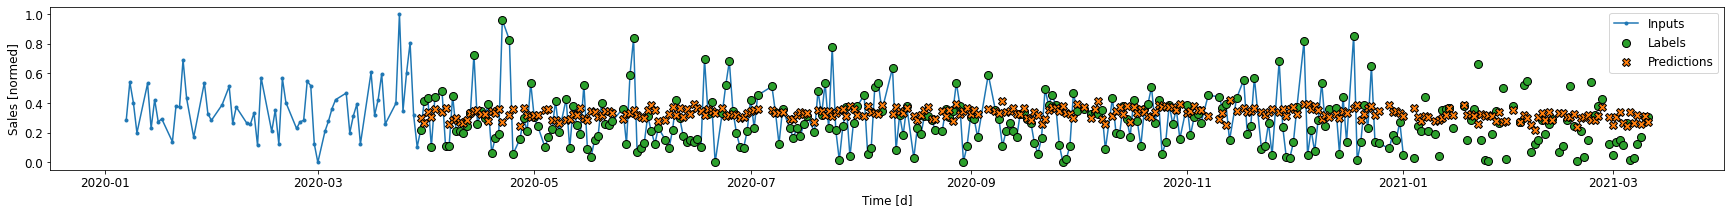

In [65]:
multi_window.plot(col="SoldVolume", model=multi_conv_model)
multi_window.plot(col="Revenue", model=multi_conv_model)
multi_window.plot(col="Sales", model=multi_conv_model)

## Recurrent Neural Network

In [66]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(64, return_sequences=False),

    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS * n_features),

    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, n_features])
])


history = compile_and_fit(multi_lstm_model, multi_window, lr=0.0001, patience=20)
IPython.display.clear_output()

multi_val_performance["LSTM"] = multi_lstm_model.evaluate(multi_window.valid)
multi_performance["LSTM"] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

22/22 [==============================] - 0s 16ms/step - loss: 0.1296


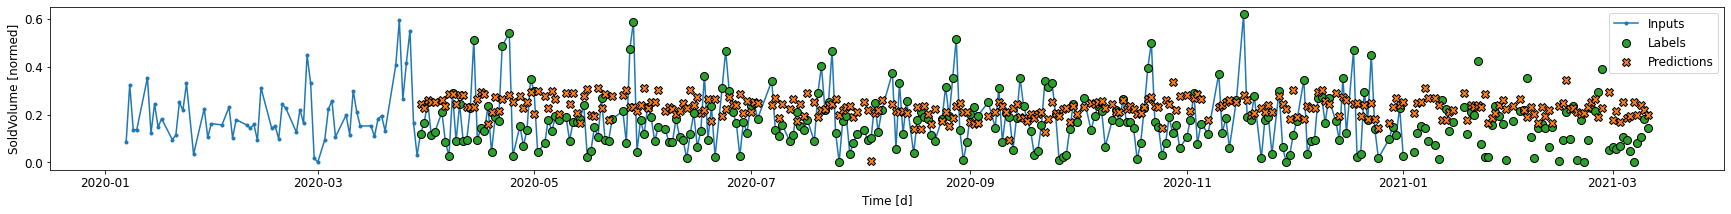

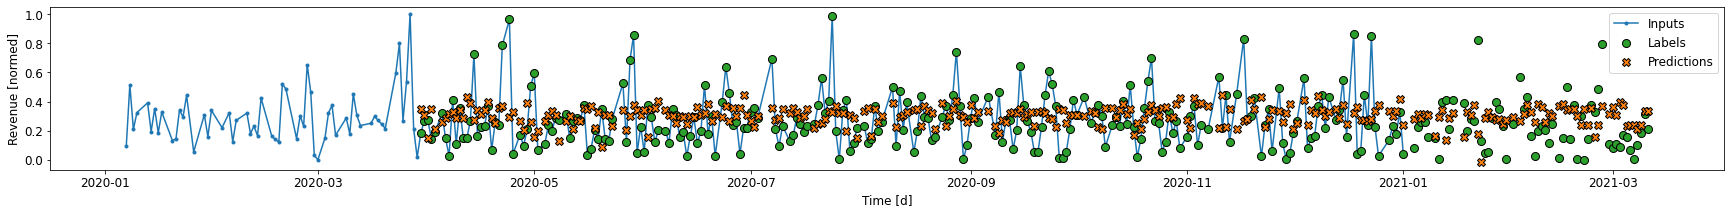

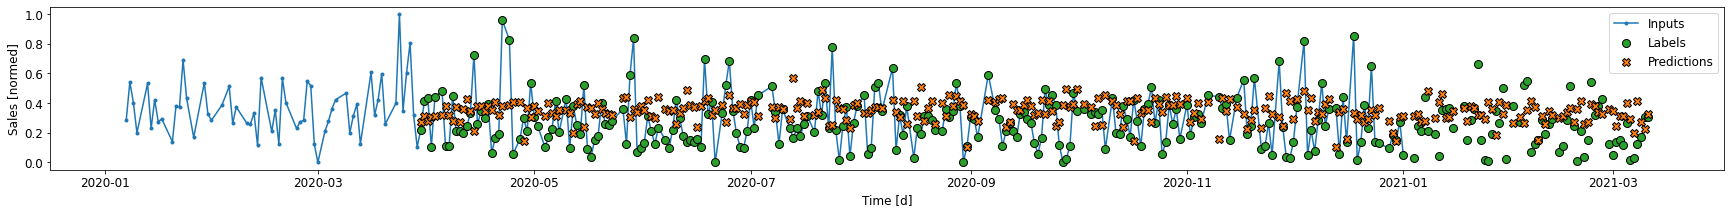

In [67]:
multi_window.plot(col="SoldVolume", model=multi_lstm_model)
multi_window.plot(col="Revenue", model=multi_lstm_model)
multi_window.plot(col="Sales", model=multi_lstm_model)

## Advanced: Autoregressive model

In [68]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, n_features, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(n_features)
    
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state, training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [69]:
feedback_model = FeedBack(units=64, n_features=n_features, out_steps=OUT_STEPS)

history = compile_and_fit(feedback_model, multi_window, lr=0.0001, patience=20)
IPython.display.clear_output()

multi_val_performance["AR LSTM"] = feedback_model.evaluate(multi_window.valid)
multi_performance["AR LSTM"] = feedback_model.evaluate(multi_window.test, verbose=0)

22/22 [==============================] - 1s 27ms/step - loss: 0.0632


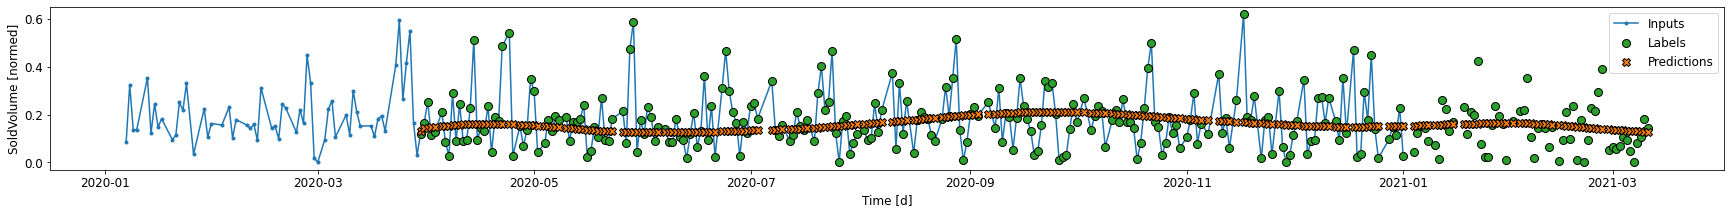

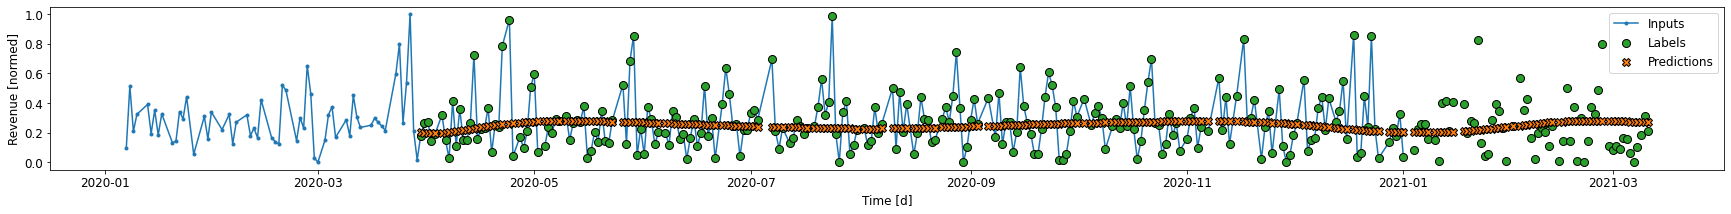

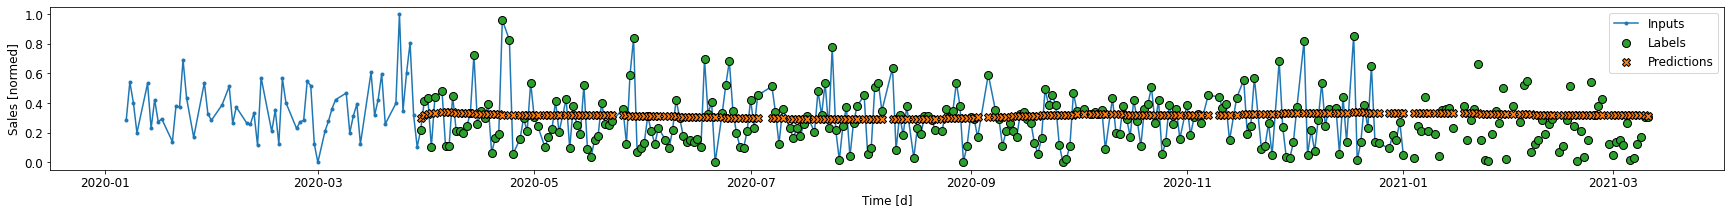

In [70]:
multi_window.plot(col="SoldVolume", model=feedback_model)
multi_window.plot(col="Revenue", model=feedback_model)
multi_window.plot(col="Sales", model=feedback_model)

## Performance

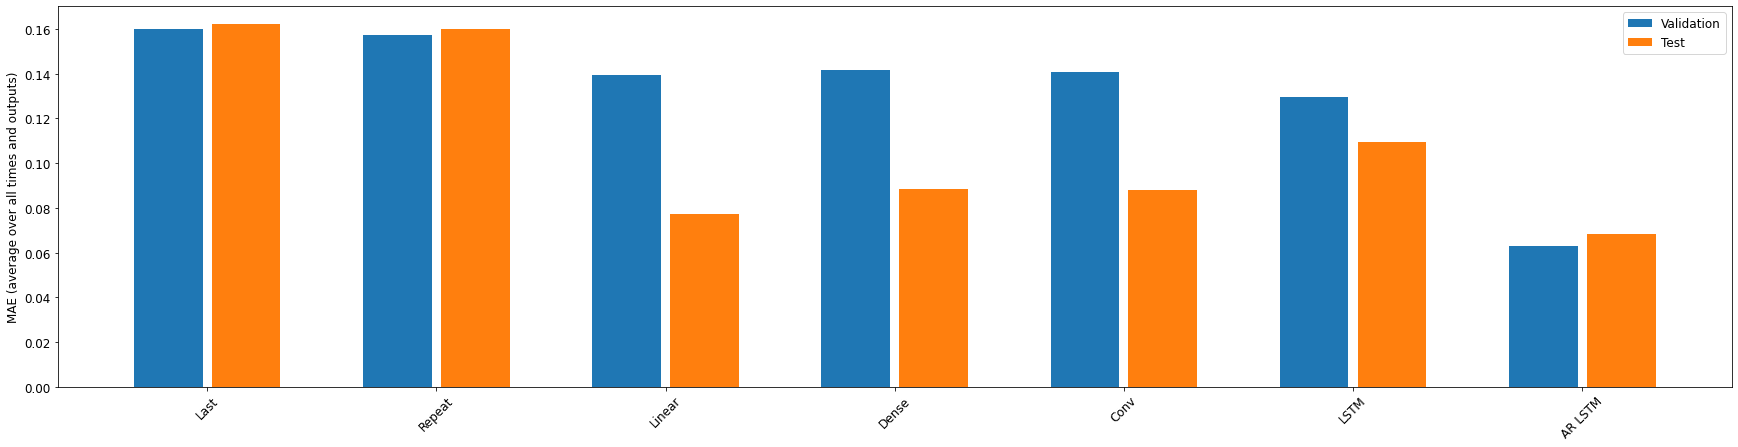

In [71]:
val_mae = [v for v in multi_val_performance.values()]
test_mae = [v for v in multi_performance.values()]

x = np.arange(len(multi_performance))
width = 0.3

plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f"MAE (average over all times and outputs)")
_ = plt.legend()

In [72]:
for name, value in multi_performance.items():
    print(f"{name:10s}: {value:0.4f}")

Last      : 0.1621
Repeat    : 0.1600
Linear    : 0.0772
Dense     : 0.0886
Conv      : 0.0882
LSTM      : 0.1097
AR LSTM   : 0.0683
